In [1]:
#Importing Importent libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
#Importing Datasets

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Data/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Data/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Data/test.csv')

In [4]:
train.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
66120,b0ccc2ee778d32fe,"For the record, I did have a valid reason for ...",1,0,1,0,1,0
167697,20b884b9ac6f4a85,""" \n\n == Programming Paradigm? == \n\n As a s...",0,0,0,0,0,0
75977,cb51583c2e91cf7f,HE SHOULD HAVE A PAGE,0,0,0,0,0,0


In [5]:
test.sample(3)

,id,content,lang
8977,8977,"«Автосуицид» — само самоубийство, «и etc.» ...",ru
29199,29199,"Sem sacanagem, dá uma lida no artigo no artigo...",pt
3592,3592,Aleviler Ayşe yi kabul etmez çünkü Ayşe denile...,tr


In [ ]:
print(f"Traing Data Shape : {train.shape}\nTest Data Shape : {test.shape}\nValidation Data Shape : {validation.shape}")

Traing Data Shape : (223549, 8)
Test Data Shape : (63812, 3)
Validation Data Shape : (8000, 4)


In [6]:
#Select Necessary featurs

train = train[["comment_text","toxic"]]
test = test[["content","lang"]]

In [7]:
train.sample(1)

,comment_text,toxic
104371,"DYK \n\nHi, well done! )Chamossaire is another...",0


In [ ]:
train.toxic.value_counts()

0    10865
1     1136
Name: toxic, dtype: int64

In [ ]:
train.shape

(223549, 2)

In [ ]:
test.shape

(63812, 2)

In [8]:
train = train.loc[:12000,:]
train.shape

(12001, 2)

In [9]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(train, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in train[train.toxic==category]['comment_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)
    
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    



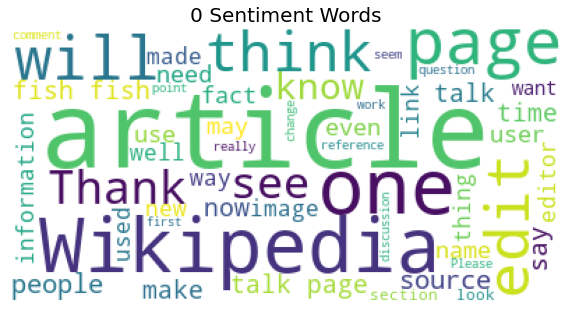

In [ ]:
wordcount_gen(train, 0)

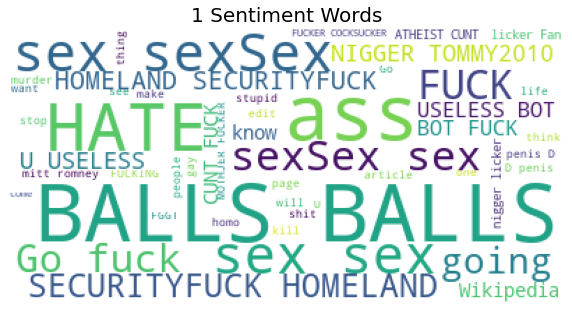

In [ ]:
wordcount_gen(train, 1)

In [10]:
train["comment_text"][5]

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [11]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [12]:
def roc_auc(predictions,target):
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [13]:
#Separate Dataset Train and Validation

xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [14]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [15]:
xtrain_pad
word_index["who"]

65

In [16]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/data/Data/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [04:36, 7956.45it/s]

Found 2196017 word vectors.


In [17]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43496/43496 [00:00<00:00, 338690.15it/s]


In [18]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 300)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 13,591,201
Trainable params: 542,101
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 673 ms, sys: 170 ms, total: 844 ms
Wall time: 1.43 s


In [19]:
#Model Traning

models = model.fit(xtrain_pad, ytrain, epochs=2, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/2
150/150 [==============================] - 1153s 8s/step - loss: 0.2008 - accuracy: 0.9320
Epoch 2/2
150/150 [==============================] - 1106s 7s/step - loss: 0.1278 - accuracy: 0.9551


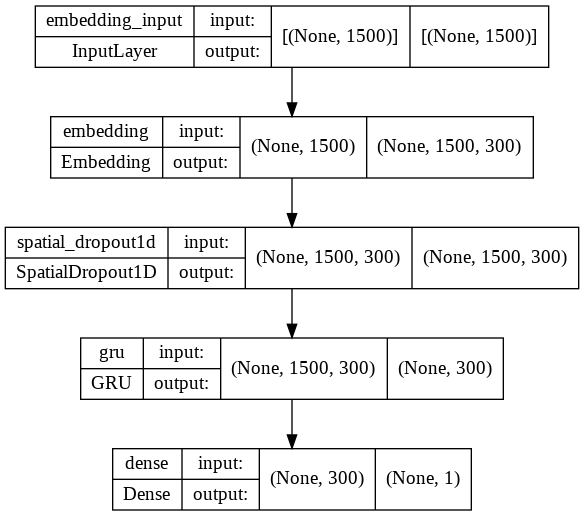

In [20]:
keras.utils.plot_model(model,"GRU_Model.png",show_shapes=True)

In [21]:
model.layers

In [22]:
hidden = model.layers[1]
hidden.name

'spatial_dropout1d'

In [23]:
model.get_layer(hidden.name) is hidden

True

In [26]:
models.params

{'epochs': 2, 'steps': 150, 'verbose': 1}

In [27]:
models.history.keys()

dict_keys(['loss', 'accuracy'])

In [28]:
acc = models.history['accuracy']

loss = models.history['loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

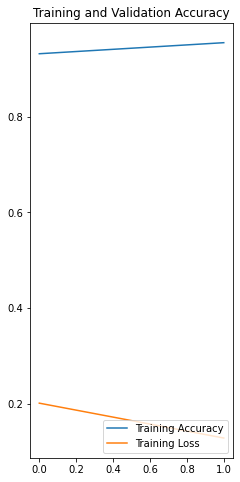

In [29]:
EPOCHS = 2

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



In [30]:
#Model Evaluation
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.98%


In [31]:
scores_model = []
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})
scores_model

[{'AUC_Score': 0.9765237143818211, 'Model': 'LSTM'}]

In [32]:
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [33]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')